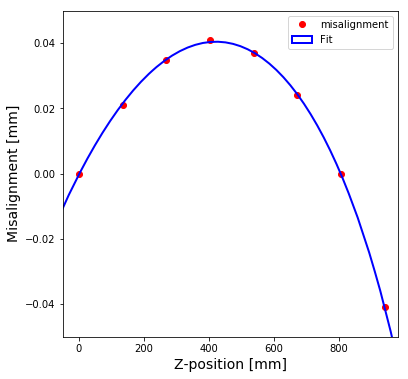

In [80]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

"""Demonstration of least-squares fitting of ellipses
    __author__ = "Ben Hammel, Nick Sullivan-Molina"
    __credits__ = ["Ben Hammel", "Nick Sullivan-Molina"]
    __maintainer__ = "Ben Hammel"
    __email__ = "bdhammel@gmail.com"
    __status__ = "Development"
    Requirements 
    ------------
    Python 2.X or 3.X
    numpy
    matplotlib
    References
    ----------
    (*) Halir, R., Flusser, J.: 'Numerically Stable Direct Least Squares 
        Fitting of Ellipses'
    (**) http://mathworld.wolfram.com/Ellipse.html
    (***) White, A. McHale, B. 'Faraday rotation data analysis with least-squares 
        elliptical fitting'
"""

class LSqEllipse:

    def fit(self, data):
        """Lest Squares fitting algorithm 
        Theory taken from (*)
        Solving equation Sa=lCa. with a = |a b c d f g> and a1 = |a b c> 
            a2 = |d f g>
        Args
        ----
        data (list:list:float): list of two lists containing the x and y data of the
            ellipse. of the form [[x1, x2, ..., xi],[y1, y2, ..., yi]]
        Returns
        ------
        coef (list): list of the coefficients describing an ellipse
           [a,b,c,d,f,g] corresponding to ax**2+2bxy+cy**2+2dx+2fy+g
        """
        x, y = numpy.asarray(data, dtype=float)

        #Quadratic part of design matrix [eqn. 15] from (*)
        D1 = numpy.mat(numpy.vstack([x**2, x*y, y**2])).T
        #Linear part of design matrix [eqn. 16] from (*)
        D2 = numpy.mat(numpy.vstack([x, y, numpy.ones(len(x))])).T
        
        #forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T*D1
        S2 = D1.T*D2
        S3 = D2.T*D2  
        
        #Constraint matrix [eqn. 18]
        C1 = numpy.mat('0. 0. 2.; 0. -1. 0.; 2. 0. 0.')

        #Reduced scatter matrix [eqn. 29]
        M=C1.I*(S1-S2*S3.I*S2.T)

        #M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this equation [eqn. 28]
        eval, evec = numpy.linalg.eig(M) 

        # eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = 4*numpy.multiply(evec[0, :], evec[2, :]) - numpy.power(evec[1, :], 2)
        a1 = evec[:, numpy.nonzero(cond.A > 0)[1]]
        
        #|d f g> = -S3^(-1)*S2^(T)*|a b c> [eqn. 24]
        a2 = -S3.I*S2.T*a1
        
        # eigenvectors |a b c d f g> 
        self.coef = numpy.vstack([a1, a2])
        self._save_parameters()
            
    def _save_parameters(self):
        """finds the important parameters of the fitted ellipse
        
        Theory taken form http://mathworld.wolfram
        Args
        -----
        coef (list): list of the coefficients describing an ellipse
           [a,b,c,d,f,g] corresponding to ax**2+2bxy+cy**2+2dx+2fy+g
        Returns
        _______
        center (List): of the form [x0, y0]
        width (float): major axis 
        height (float): minor axis
        phi (float): rotation of major axis form the x-axis in radians 
        """

        #eigenvectors are the coefficients of an ellipse in general form
        #a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0 [eqn. 15) from (**) or (***)
        a = self.coef[0,0]
        b = self.coef[1,0]/2.
        c = self.coef[2,0]
        d = self.coef[3,0]/2.
        f = self.coef[4,0]/2.
        g = self.coef[5,0]
        
        #finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d-b*f)/(b**2.-a*c)
        y0 = (a*f-b*d)/(b**2.-a*c)
        
        #Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
        denominator1 = (b*b-a*c)*( (c-a)*numpy.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        denominator2 = (b*b-a*c)*( (a-c)*numpy.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        width = numpy.sqrt(numerator/denominator1)
        height = numpy.sqrt(numerator/denominator2)

        # angle of counterclockwise rotation of major-axis of ellipse to x-axis [eqn. 23] from (**)
        # or [eqn. 26] from (***).
        phi = .5*numpy.arctan((2.*b)/(a-c))

        self._center = [x0, y0]
        self._width = width
        self._height = height
        self._phi = phi

    @property
    def center(self):
        return self._center

    @property
    def width(self):
        return self._width

    @property
    def height(self):
        return self._height

    @property
    def phi(self):
        """angle of counterclockwise rotation of major-axis of ellipse to x-axis 
        [eqn. 23] from (**)
        """
        return self._phi

    def parameters(self):
        return self.center, self.width, self.height, self.phi


def make_test_ellipse(center=[1,1], width=1, height=.6, phi=3.14/5):
    """Generate Elliptical data with noise
    
    Args
    ----
    center (list:float): (<x_location>, <y_location>)
    width (float): semimajor axis. Horizontal dimension of the ellipse (**)
    height (float): semiminor axis. Vertical dimension of the ellipse (**)
    phi (float:radians): tilt of the ellipse, the angle the semimajor axis
        makes with the x-axis 
    Returns
    -------
    data (list:list:float): list of two lists containing the x and y data of the
        ellipse. of the form [[x1, x2, ..., xi],[y1, y2, ..., yi]]
    """
    t = numpy.linspace(0, 2*numpy.pi, 100)
    x_noise, y_noise = numpy.random.rand(2, len(t))
    
    ellipse_x = center[0] + width*numpy.cos(t)*numpy.cos(phi)-height*numpy.sin(t)*numpy.sin(phi) + x_noise/2.
    ellipse_y = center[1] + width*numpy.cos(t)*numpy.sin(phi)+height*numpy.sin(t)*numpy.cos(phi) + y_noise/2.
    
#     print(ellipse_x)
    print(ellipse_x, ellipse_y)
    return [ellipse_x, ellipse_y]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

data = [0, 134.363, 268.72, 403.081, 537.421, 671.77, 806.103, 940.406 ], [0. ,     0.021 , 0.035 , 0.041 , 0.037 , 0.024  ,0. ,   -0.041]

lsqe = LSqEllipse()
lsqe.fit(data)
center, width, height, phi = lsqe.parameters()

plt.close('all')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(data[0], data[1], 'ro', label='misalignment', zorder=1)

ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
               edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
ax.add_patch(ellipse)

ax.set_xlim(-50, 980)
ax.set_ylim(-0.050, 0.050) 
plt.ylabel("Misalignment [mm]", fontsize=14)
plt.xlabel("Z-position [mm]", fontsize=14)

plt.legend()
plt.show()